# Section 3.2 — Confidence intervals

This notebook contains the code examples from [Section 3.2 Confidence intervals]() of the **No Bullshit Guide to Statistics**.


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/confidence_intervals"

<Figure size 432x288 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

In [5]:
#######################################################

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions



### Estimators

Recall all the estimators (functions that take samples as inputs) we defined in the previous section.

In [6]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_rvX_n20.pdf
Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_rvX_n20.png


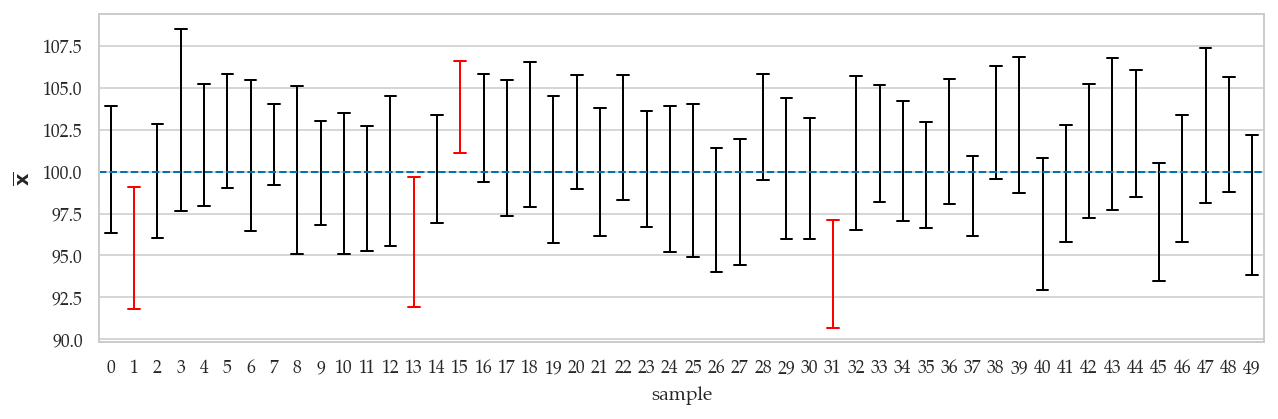

In [7]:
filename = os.path.join(DESTDIR, "confidence_intervals_mean_rvX_n20.pdf")

from scipy.stats import norm
from plot_helpers import gen_samples
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
palette = sns.color_palette(palette=["#ff0000", "#000000"])

N = 50
n = 20

# Generate N=50 samples of size n=20 from a normal dist
rvX = norm(100,10)

np.random.seed(47)
samples_df = gen_samples(rvX, n=n, N=N)
samples_df.columns = range(0,N)
df2 = samples_df.melt(var_name="sample", value_name="n")

def confint(data):
    """
    Compute 90% confidence interval.
    Note:  1.729 = tdist(19).ppf(0.95)
    """
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=1)
    se = std / np.sqrt(n)
    return [mean - 1.729*se, mean + 1.729*se]

# Add new column to indicate if CI contains mean or not
for sidx in range(0,N):
    sample = df2[df2["sample"]==sidx]["n"].values
    C_L, C_U = confint(sample)
    if C_L <= rvX.mean() and rvX.mean() <= C_U:
        outcome = 1  # includes population mean
    else:
        outcome = 0  # doesn't include population mean
    df2.loc[df2["sample"]==sidx,"success"] = outcome


with warnings.catch_warnings(), plt.rc_context({"figure.figsize":(9,3)}):
    warnings.filterwarnings('ignore', category=UserWarning)    
    ax = sns.pointplot(x="sample", y="n", hue="success", data=df2,
                       errorbar=confint, palette=palette,
                       join=False, capsize=0.5, markers=" ", errwidth=1)
    ax.set_ylabel("$\overline{\mathbf{x}}$")
    ax.axhline(y=rvX.mean(), color='b', label='Mean', linestyle='--', linewidth=1)
    ax.legend([],[], frameon=False)
    savefigure(ax, filename)

## Confidence interval constructions

$$
 CI = \left[
         F^{-1}\big(\tfrac{\alpha}{2}\big),
         F^{-1}\big(1-\tfrac{\alpha}{2}\big)
      \right]
$$

### Bootstrap confidence intervals

In [8]:
#######################################################
def bootstrap_stat(sample, statfunc, B=10000):
    """
    Compute the sampling distribiton of `statfunc`
    from `B` bootstrap samples generated from `sample`.
    """
    n = len(sample)
    bstats = []
    for i in range(0, B):
        bsample = np.random.choice(sample, n, replace=True)
        bstat = statfunc(bsample)
        bstats.append(bstat)
    return bstats

### Analytical approximations

## Confidence interval for the population mean

### Example 1: confidence interval for the mean apple weight

In [9]:
apples = pd.read_csv("../datasets/apples.csv")
asample = apples["weight"]
# asample


In [10]:
n = asample.count()
amean = mean(asample)
astd = std(asample)
sehat = astd / np.sqrt(n)

from scipy.stats import t as tdist
rvT = tdist(n-1)

t_05 = abs(rvT.ppf(0.05))
t_95 = abs(rvT.ppf(0.95))
CI_mu_tdist = [amean - t_05*sehat, amean + t_95*sehat]
CI_mu_tdist

[196.82986523723363, 208.37013476276636]

In [11]:
# ALT. setting `loc` and `scale` parameters on the T-distribution 
rvTAbar = tdist(n-1, loc=amean, scale=sehat)
rvTAbar.ppf(0.05), rvTAbar.ppf(0.95)

(196.82986523723363, 208.37013476276636)

In [12]:
# ALT2. use the scipy.stats function
from scipy.stats import t as tdist
tdist.interval(0.9, df=n-1, loc=amean, scale=sehat)

(196.82986523723363, 208.37013476276636)

In [13]:
# ALT3. use the statsmodels function
import statsmodels.stats.api as sms
sms.DescrStatsW(asample).tconfint_mean(alpha=0.1)

(196.82986523723363, 208.37013476276636)

#### Bootstrap confidence interval for the mean

In [14]:
np.random.seed(50)
ameans_boot = bootstrap_stat(asample, statfunc=mean)
CI_mu_boot = [np.percentile(ameans_boot,5),
              np.percentile(ameans_boot,95)]
CI_mu_boot

[197.23333333333332, 208.23333333333332]

In [15]:
# ALT. use the `bootstrap` function from `scipy.stats`
from scipy.stats import bootstrap

res = bootstrap((asample,),
                statistic=mean,
                vectorized=False,
                confidence_level=0.9,
                n_resamples=10000,
                method='percentile')
[res.confidence_interval.low,
 res.confidence_interval.high]

[197.13333333333333, 208.3]

## Confidence interval for the population variance

### Example 2: confidence interval for the variance of apple weights

In [16]:
n = 30
s2 = var(asample)

from scipy.stats import chi2
rvX2 = chi2(n-1)

x2_05 = rvX2.ppf(0.05)
x2_95 = rvX2.ppf(0.95)
CI_sigma2 = [(n-1)*s2/x2_95, (n-1)*s2/x2_05]
CI_sigma2

[235.7592779198888, 566.5796548600426]

#### Bootstrap confidence interval for the variance

In [17]:
np.random.seed(51)
avars_boot = bootstrap_stat(asample, statfunc=var)
CI_sigma2_boot = [np.percentile(avars_boot,5),
                  np.percentile(avars_boot,95)]
CI_sigma2_boot

[199.33379310344824, 484.7354022988503]

## Confidence interval for the difference between means

In [18]:
def calcdf(stdX, n, stdY, m):
    vX = stdX**2 / n
    vY = stdY**2 / m
    df = (vX + vY)**2 / (vX**2/(n-1) + vY**2/(m-1))
    return df

In [19]:
def pooled_var(sampleX, sampleY):
    ...


### Example 3: confidence interval for difference in electricity prices

In [20]:
eprices = pd.read_csv("../datasets/eprices.csv")
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

# sample size and std in East
nW = pricesW.count()
stdW = pricesW.std()

# sample size and std in West
nE = pricesE.count()
stdE = pricesE.std()

# standard error
seD = np.sqrt(stdW**2/nW + stdE**2/nE)
# seD

# degrees of freedom
df = calcdf(stdW, nW, stdE, nE)

# center of the CI
dhat = dmeans(pricesW, pricesE)
# dhat

from scipy.stats import t as tdist
rvT = tdist(df)

In [21]:
t_05 = abs(rvT.ppf(0.05))
t_95 = abs(rvT.ppf(0.95))
CI_Dprices_tdist = [dhat - t_05*seD, dhat + t_95*seD]
CI_Dprices_tdist

[1.9396575883681457, 4.060342411631854]

In [22]:
# Or use a t dist with loc and scale parameters: 
rvD = tdist(df, loc=dhat, scale=seD)
rvD.ppf(0.05), rvD.ppf(0.95)  # == rvD.interval(0.9)

(1.9396575883681457, 4.060342411631854)

In [23]:
# ALT1. using statsmodels
import numpy as np, statsmodels.stats.api as sms
cm = sms.CompareMeans(sms.DescrStatsW(pricesW), sms.DescrStatsW(pricesE))
cm.tconfint_diff(alpha=0.1, usevar='unequal')

(1.9396575883681464, 4.060342411631853)

In [24]:
# ALT2. using pingouin
import pingouin as pg
res = pg.ttest(pricesW, pricesE, confidence=0.9, correction=True)
res["CI90%"].values[0]

array([1.93965759, 4.06034241])

#### Bootstrap confidence interval

In [25]:
# compute bootstrap estimates for mean in each group
meanW_boot = bootstrap_stat(pricesW, statfunc=mean)
meanE_boot = bootstrap_stat(pricesE, statfunc=mean)

# compute the difference between means from bootstrap samples
dmeans_boot = []
for bmeanW, bmeanE in zip(meanW_boot, meanE_boot):
    d_boot = bmeanW - bmeanE
    dmeans_boot.append(d_boot)

CI_Dprices_boot = [np.percentile(dmeans_boot,5),
                 np.percentile(dmeans_boot,95)]
CI_Dprices_boot

[2.1000000000000014, 3.9333333333333336]

### Example 4: confidence interval for the difference in sleep scores

In [26]:
doctors = pd.read_csv("../datasets/doctors.csv")
scoresU = doctors[doctors["location"]=="urban"]["score"]
scoresR = doctors[doctors["location"]=="rural"]["score"]

# estimate (center of the CI)
dhat = dmeans(scoresR, scoresU)
dhat

# sample size and std for urban group
nU = scoresU.count()
stdU = scoresU.std()

# sample size and std for rural group
nR = scoresR.count()
stdR = scoresR.std()

# standard error
seD = np.sqrt(stdU**2/nU + stdR**2/nR)

# degrees of freedom
df = calcdf(stdU, nU, stdR, nR)

from scipy.stats import t as tdist
rvT = tdist(df)

In [27]:
t_05 = abs(rvT.ppf(0.05))
t_95 = abs(rvT.ppf(0.95))
CI_Dscores_tdist = [dhat - t_05*seD, dhat + t_95*seD]
CI_Dscores_tdist

[0.768077404177574, 3.679132248914442]

In [28]:
# Or use a t dist with loc and scale parameters:
rvD = tdist(df, loc=dhat, scale=seD)
rvD.ppf(0.05), rvD.ppf(0.95)

(0.768077404177574, 3.679132248914442)

#### Bootstrap confidence interval

In [29]:
# compute bootstrap estimates for mean in each group
meansU_boot = bootstrap_stat(scoresU, statfunc=mean)
meansR_boot = bootstrap_stat(scoresR, statfunc=mean)

# compute the difference between means in bootstrap samples
dmeans_boot = []
for bmeanR, bmeanU in zip(meansU_boot, meansR_boot):
    d_boot = bmeanR - bmeanU
    dmeans_boot.append(d_boot)

CI_Dscores_boot = [np.percentile(dmeans_boot,5),
                   np.percentile(dmeans_boot,95)]
CI_Dscores_boot

[-3.6598981900452414, -0.8212669683257872]

## Explanations

## Discussion

### Comparing analytical formulas and bootstrap estimates


### Alternative bootstrap estimators

Mention more advanced bootstrap methods like BCa exist (--> see problem PZZ)

# CUT MATERIAL

In [30]:
# simulation based sampling distributoin
def gen_sampling_dist(rv, statfunc, n, N=10000):
    stats = []
    for i in range(0, N):
        sample = rv.rvs(n)
        stat = statfunc(sample)
        stats.append(stat)
    return stats

In [31]:
from scipy.stats import norm

muK = 1000
sigmaK = 10
rvK = norm(muK, sigmaK)

In [32]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
ksample02.values

array([ 995.83,  999.44,  978.64, 1016.4 ,  982.07,  991.58, 1005.03,
        987.55,  989.42,  990.91, 1005.51, 1022.92, 1000.42,  988.82,
       1005.39,  994.04,  999.81, 1011.75,  992.52, 1000.09])

In [33]:
# n = 20
# xbar = mean(ksample02)
# xstd = std(ksample02)
# sehat = xstd / np.sqrt(n)

# from scipy.stats import t as tdist
# rvT = tdist(n-1)

# t_05 = abs(rvT.ppf(0.05))
# t_95 = abs(rvT.ppf(0.95))
# CI_mu_tdist = [xbar - t_05*sehat, xbar + t_95*sehat]
# CI_mu_tdist

In [34]:
# # true sampling distribuiton (simulation)
# kbars = gen_sampling_dist(rvK, statfunc=mean, n=20)
# [np.percentile(kbars,5),
#  np.percentile(kbars,95)]

In [35]:
# variance
n = 20
s2 = var(ksample02)

from scipy.stats import chi2
rvX2 = chi2(n-1)

x2_05 = rvX2.ppf(0.05)
x2_95 = rvX2.ppf(0.95)
CI_sigma2_tdist = [(n-1)*s2/x2_95, (n-1)*s2/x2_05]
CI_sigma2_tdist

[78.35958956911868, 233.47152020964367]

In [36]:
np.random.seed(48)
kvars_boot = bootstrap_stat(ksample02, statfunc=var)
CI_sigma2_boot = [np.percentile(kvars_boot,5),
                  np.percentile(kvars_boot,95)]
CI_sigma2_boot

[61.42017901315756, 181.44746289473633]

In [37]:
# true
kvars = gen_sampling_dist(rvK, statfunc=var, n=20)
[np.percentile(kvars,5),
 np.percentile(kvars,95)]

[52.62431855846445, 160.48062854014054]